In [1]:
import torch
import numpy as np
import pandas as pd 
from transformers import AutoTokenizer
from datasets import load_dataset
import datasets
import matplotlib.pyplot as plt

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pd.set_option('display.max_colwidth', None)
print(device)

cuda:0


In [2]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    pd.set_option('display.max_colwidth', None)
    return df

### Removing <br /><br /> from the dataset
def preprocess_function_1(examples):
    for i in range(len(examples['text'])):
        examples['text'][i] = examples['text'][i].replace('<br /><br />', " ")
    return examples

### Tokenizing words into integer for embedding layer in BERT
seq_len = 128
def preprocess_function_2(examples):
    return tokenizer(examples['text'],max_length=seq_len, padding = "max_length",truncation=True)

### dataset must be converted to pd dataframe first
### splits any example that are too long into two examples instead 
def chunk_half_fullstop_examples(dataset):
    for index, row in dataset.iterrows():
        sentence = row["text"][:]
        half_sentence_index = int(len(sentence) * 0.5);
        full_stop_index = sentence.find(".", half_sentence_index, len(sentence))
        if len(sentence.split(" ")) < 128 or full_stop_index == -1:
            continue
        else:
            first_half = sentence[: full_stop_index + 1] #including the fullstop
            second_half = sentence[full_stop_index + 1:]

            # Don't do anything if word is less than 128
            # We don't want to affect the exisitng accuracy since our input sequence length is 128. 
            if len(first_half.split(" ")) < 128:
                continue
            else:
                # Consider it as another example if the second half number of words > 50? 
                # Else if it is too short, it might not be a good training example
                if len(second_half.split(" ")) > 50:
                    # Truncate the sample to the first half only if we are generating an additional example from the second half
                    dataset.at[index, "text"] = first_half[:]
                    # Add second half to dataset with the same label
                    pd_series = pd.Series({'text': second_half, 'label': row["label"]})
                    dataset = pd.concat([dataset, pd_series.to_frame().T], ignore_index=True)
    return dataset

In [3]:
### Tokenizer to preprocess the input before feeding into the model
### Using a sequence length of 128 for IMDb for the sake of faster finetuning time 
seq_len = 128
model_checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, model_max_length = seq_len)

In [4]:
dataset = load_dataset("imdb")
dataset = dataset.map(preprocess_function_1, batched = True)

dataset_train_original = dataset['train']
dataset_val = dataset['test']

Found cached dataset imdb (/home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f499865304210fea.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-917dfd9df9598baf.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-d55381d75d3316f0.arrow


### Increasing IMDb Training Dataset

In [5]:
dataset = load_dataset("imdb")
dataset = dataset.map(preprocess_function_1, batched = True)

dataset_train_original = dataset['train']
dataset_val = dataset['test']

print("----------Before Increasing Training Dataset----------")
print(f"# of Train Sequences: {len(dataset_train_original)},\
        # of Validation Sequences: {len(dataset_val)}")

# convert dataset_train to dataframe to increase train dataset size
dataset_train_class_labels = dataset_train_original.features.copy()
dataset_train = pd.DataFrame(dataset_train_original)

# split two times 
dataset_train = chunk_half_fullstop_examples(dataset_train)
dataset_train = chunk_half_fullstop_examples(dataset_train)

# convert dataset_train back to Dataset for training
dataset_train = datasets.Dataset.from_pandas(dataset_train)
dataset_train = dataset_train.cast(dataset_train_class_labels)

print("----------After Increasing Training Dataset----------")
print(f"# of Train Sequences: {len(dataset_train)},\
        # of Validation Sequences: {len(dataset_val)}")

Found cached dataset imdb (/home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f499865304210fea.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-917dfd9df9598baf.arrow
Loading cached processed dataset at /home/weiming/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-d55381d75d3316f0.arrow


----------Before Increasing Training Dataset----------
# of Train Sequences: 25000,        # of Validation Sequences: 25000


Casting the dataset:   0%|          | 0/4 [00:00<?, ?ba/s]

----------After Increasing Training Dataset----------
# of Train Sequences: 38767,        # of Validation Sequences: 25000


### Comparing Sequence Length Distribution of Original Train Dataset and New Train Dataset

Min Seq Length (Train Original): 10
Max Seq Length (Train Original): 2460
Min Seq Length (Train New): 10
Max Seq Length (Train New): 678


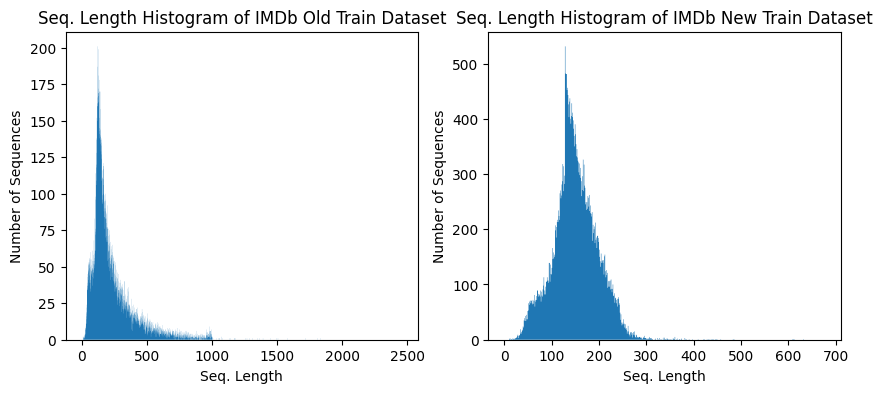

In [6]:
list_of_seq_len_train = []
list_of_seq_len_val = []
for seq in dataset_train_original["text"]:
    # For each sequence, count how many words are there
    list_of_seq_len_train.append(len(seq.split(" ")))

for seq in dataset_train["text"]:
    # For each sequence, count how many words are there
    list_of_seq_len_val.append(len(seq.split(" ")))

print(f"\
Min Seq Length (Train Original): {min(list_of_seq_len_train)}\n\
Max Seq Length (Train Original): {max(list_of_seq_len_train)}\n\
Min Seq Length (Train New): {min(list_of_seq_len_val)}\n\
Max Seq Length (Train New): {max(list_of_seq_len_val)}\
")

bins_train = np.arange(0, max(list_of_seq_len_train))
seq_len_hist_train, bins_train = np.histogram(list_of_seq_len_train, bins_train)

bins_val = np.arange(0, max(list_of_seq_len_val))
seq_len_hist_val, bins_val = np.histogram(list_of_seq_len_val, bins_val)

f, ax = plt.subplots(nrows = 1, ncols=2, figsize = (10, 4))

ax[0].stairs(seq_len_hist_train, bins_train, fill=True)
ax[0].set_xlabel("Seq. Length")
ax[0].set_ylabel("Number of Sequences")
ax[0].set_title("Seq. Length Histogram of IMDb Old Train Dataset")

ax[1].stairs(seq_len_hist_val, bins_val, fill=True)
ax[1].set_xlabel("Seq. Length")
ax[1].set_ylabel("Number of Sequences")
ax[1].set_title("Seq. Length Histogram of IMDb New Train Dataset")
plt.show()